# Forecasting Model with SARIMAX

This is the third notebook of a series to present different forecasting models. We will be using the **SARIMAX** model provided by **statsmodels** library. ARIMA stands for **Seasonal AutoRegressive Integrated Moving Average with eXogenous variables**.

As we saw in the ARIMA model, SARIMAX also requires the following arguments:

1. **p** is the number of autoregressive terms
2. **d** is the number of nonseasonal differences
3. **q** is the number of lagged forecast errors

But the main difference is that SARIMAX can deal with **non-stationary** time series (observations that can change over the time). It can learn from the seasonality and exogenous variables, which basically are variables that are not part of the time serieas but can still influence.

Extra values we can pass to SARIMAX:

* Seaonal order
* Exogenous variables

We will find these values for our dataset in the **Decomposing The Data Set** step.

The dataset is the **Alphabet Inc.** daily stock prices that can be downloaed from [Yahoo Finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG). Data ranged from Jan-2020 to Dec-2023.

The target colum is **Close** column. It represents the stock price at the end of the day.

Here are the steps we will follow in each notebook:

1. Data Preparation
2. Decomposing The Data Set
3. Traing The Model
4. Evaluate The Model

# Data Preparation

In [135]:
# Run this command if pmdarima is not installed
!pip install pmdarima

In [159]:
# Import usefull libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deactivate warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [137]:
# Collect the dataset
df = pd.read_csv('GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
1,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
3,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
4,2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


In [138]:
# Check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1006 non-null   object 
 1   Open       1006 non-null   float64
 2   High       1006 non-null   float64
 3   Low        1006 non-null   float64
 4   Close      1006 non-null   float64
 5   Adj Close  1006 non-null   float64
 6   Volume     1006 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.1+ KB


In [139]:
# Use date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Remove duplicates based on index, keep first found
df = df[~df.index.duplicated(keep='first')]
df.asfreq('D')
df.sort_index(inplace=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


# Decomposing The Data Set

We will discover:

* Trends
* Seasonality
* Residuals

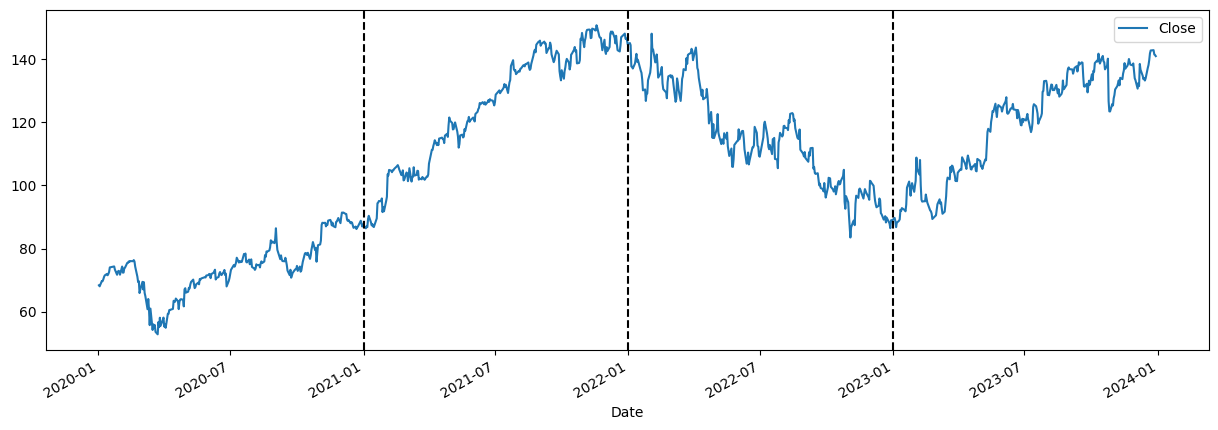

In [140]:
# Plot the data
vlines = ['2021-01-01', '2022-01-01', '2023-01-01']

df.plot(y='Close', figsize=(15,5))

for line in vlines:
  plt.axvline(x=line, color='black', linestyle='--')

plt.show()

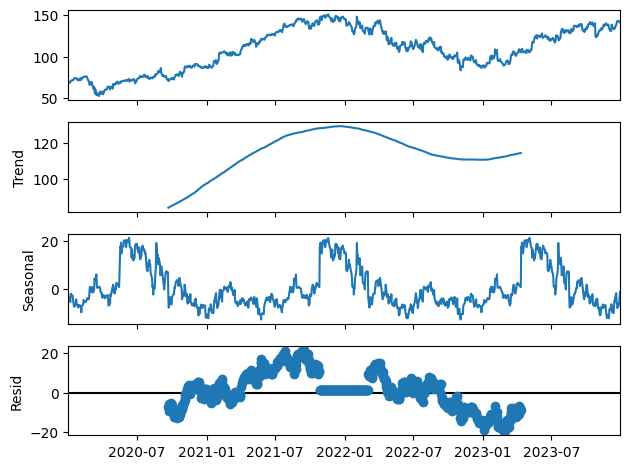

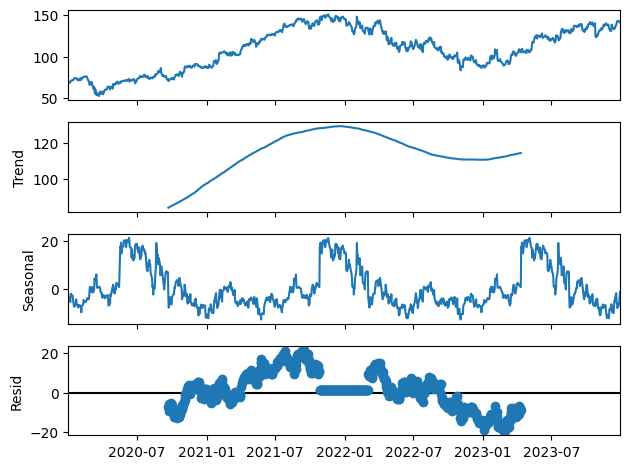

In [141]:
# Plot the decompose item
series = df[['Close']].copy()
decompose_result_mult = seasonal_decompose(series, model="additive", period=365)


decompose_result_mult.plot()

### Find if the series is non-stationary using Augmented Dickey-Fuller Test



In [142]:
# Call the adfuller() class
result = adfuller(df['Close'])

# Print the results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

# If p-value is more that 0.05 means that the data series is non-stationary
# otherwise it is stationary
for key, value in result[4].items():
  print('\t%s: %.2f' % (key, value))

ADF Statistic: -1.511345
p-value: 0.527892
Critical Values:
	1%: -3.44
	5%: -2.86
	10%: -2.57


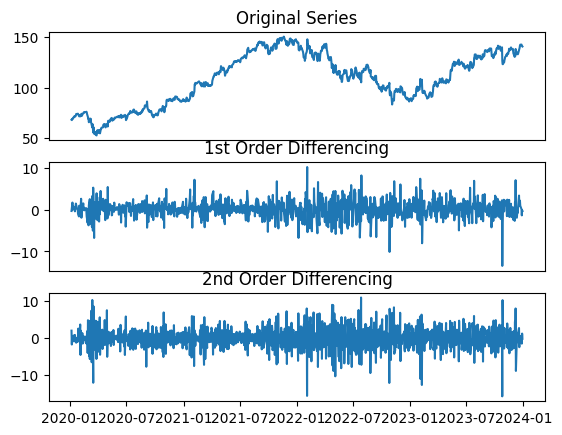

In [143]:
# We can plot the 1st and 2nd order differencing to see if the series become stationary

fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df['Close']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df['Close'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df['Close'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

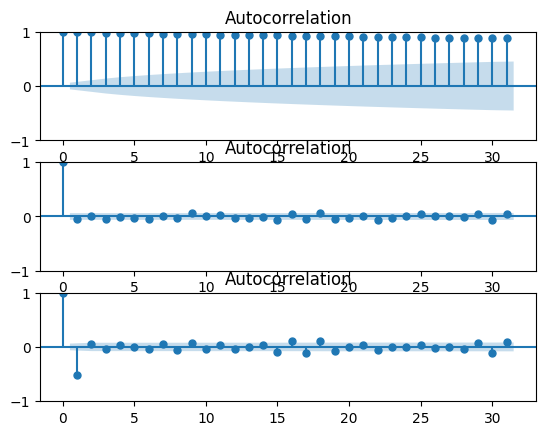

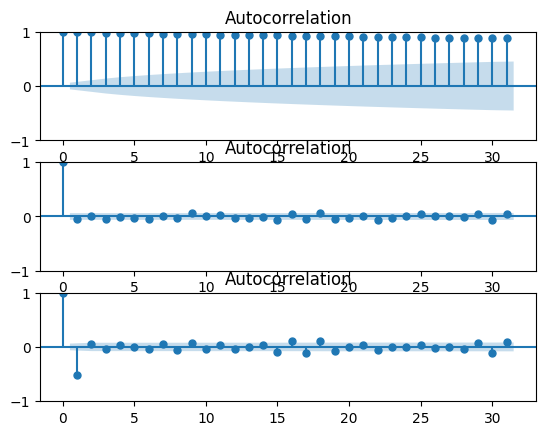

In [144]:
# as the dataset is non-stationary we need to identify the number of nonseasonal differences
# We can use the autocorrelation plot from statsmodels, apply two differences levels and compare if noise reduces

fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df['Close'], ax=ax1)
plot_acf(df['Close'].diff().dropna(), ax=ax2)
plot_acf(df['Close'].diff().diff().dropna(), ax=ax3)

In the previous output we can see that we reduced the noise of the series by the first-order difference.

***d = 1***

In [145]:
d = 1

### Finding p - the number of autoregressive terms

We will use the partial autocorrelation function plot to draw and find the correlation between the series and its lags.

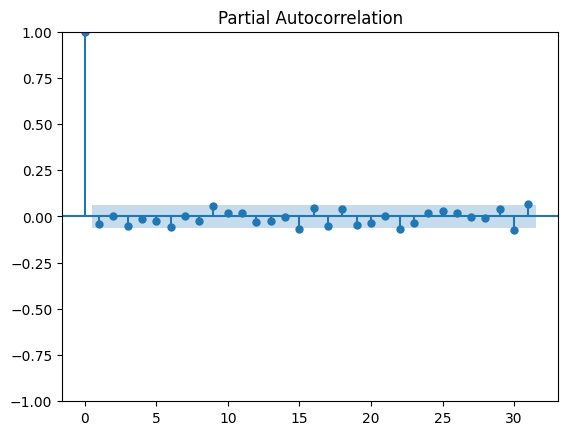

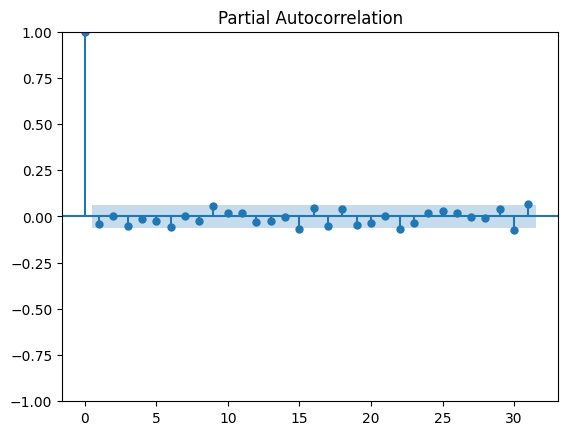

In [146]:
plot_pacf(df['Close'].diff().dropna())

As the first lag is way out of the limit (blue area):

***p = 1***

In [147]:
p = 1

### Finding q - the number of lagged forecast errors

We can use the ACF plot and depending on the lags that are out of the significance limit we can define **q**

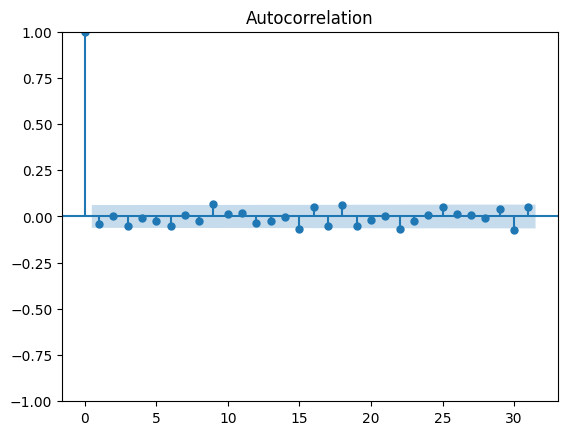

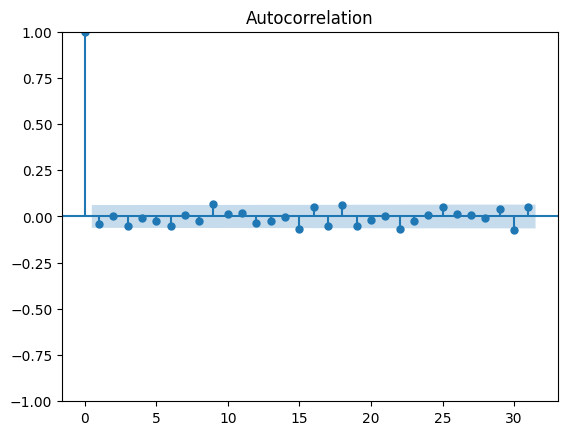

In [148]:
plot_acf(df['Close'].diff().dropna())

***q = 1***

In [149]:
q =1

### Finding the Seasonal Order values

We can use the `pmdarima` library to find the optimal values for the seasonal order

The important parts we will focus from the result are:

* Dep. Variable: The name of the dependent variable in the model.
* Model: The type of model that was fitted.
* Method: The method that was used to estimate the parameters of the model.

In [150]:
# fit the model to get the optimal values
seasonal_model = pm.auto_arima(df['Close'], seasonal=True, m=12)

# review summary
seasonal_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1006
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2201.911
Date:                Thu, 01 Feb 2024   AIC                           4405.822
Time:                        17:52:39   BIC                           4410.735
Sample:                             0   HQIC                          4407.689
                               - 1006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.6834      0.131     35.707      0.000       4.426       4.941
===================================================================================
Ljung-Box (L1) (Q):                   1.88   Jarque-Bera (JB):               416.44
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We have our optimal seasonal_order

In [151]:
# Save the values
s_p = 0
s_d = 1
s_q = 0

# Traing The Model


In [152]:
# Select the exogenous variables

# Open = stock price at the start of the day
# Volume = volume on stock shares
exog = ['Open', 'Volume']

In [154]:
# Split the dataset into training and test data
split_point = int(0.8 * len(df))

# Split the list into training and testing sets
training_data = df[:split_point].squeeze()
testing_data = df[split_point:].squeeze()

In [155]:
# Define the SARIMAX model
# pass the found p,d,q
model = SARIMAX(training_data['Close'], exog=training_data[exog], order=(p,d,q), seasonal_order=(s_p, s_d, s_q, 12))
model_fit = model.fit()

# Evaluate The Model

In [156]:
# Make predictions for the test set  2
forecast = model_fit.get_forecast(steps=len(testing_data), exog=testing_data[exog])

# Get the forecasted values
forecasted_values = forecast.predicted_mean
forecasted_values

804      91.136296
805      91.537200
806      92.848220
807      93.704566
808      97.036720
           ...    
1001    122.733476
1002    124.154810
1003    121.995457
1004    122.669850
1005    120.102564
Name: predicted_mean, Length: 202, dtype: float64

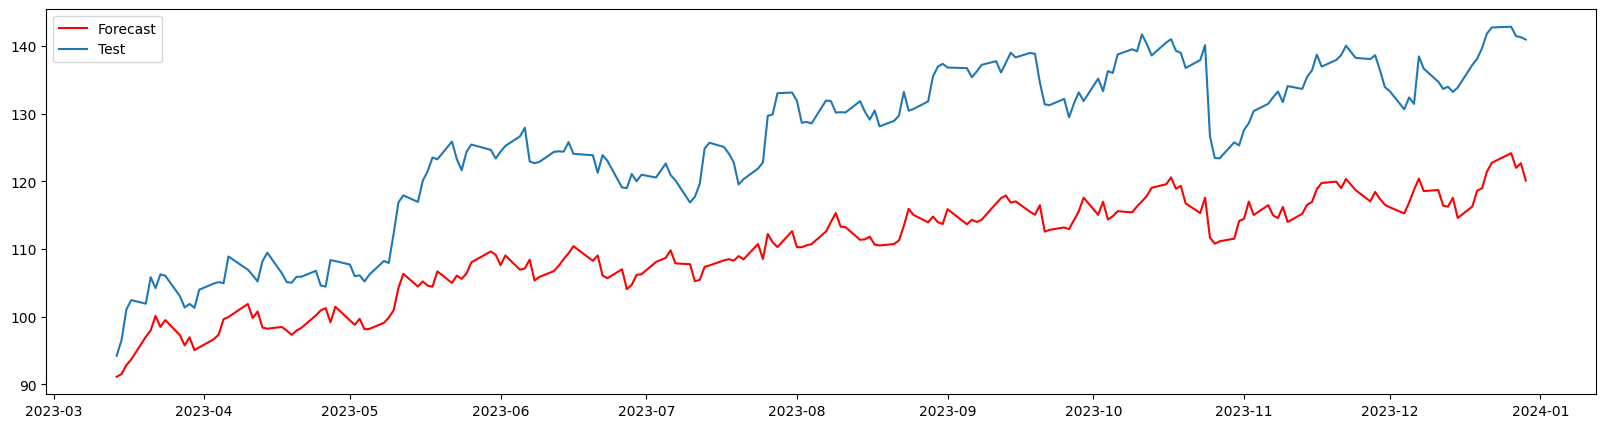

In [157]:
# Plot test and forecast data

plt.figure(figsize=(20,5))

plt.plot(testing_data.index, forecasted_values, label='Forecast', color='red')
plt.plot(testing_data.index, testing_data['Close'], label='Test')

plt.legend()
plt.show()

### Evaluation Metrics

* MAE (Mean Absolute Error): The average of the absolute differences between predicted and actual values.
* RMSE (Root Mean Squared Error): The square root of the average of the squared differences between predicted and actual values.
* SMAPE (Symmetric Mean Absolute Percentage Error): The average of the absolute percentage differences between predicted and actual values, scaled by the sum of the absolute values of the predicted and actual values.

In [171]:
# Mean absolute error
mae = mean_absolute_error(testing_data['Close'], forecasted_values)

# Root mean square error
mse = mean_squared_error(testing_data['Close'], forecasted_values)
rmse = np.sqrt(mse)

#Symettric MAPE
actual = np.array(testing_data['Close'])
predicted = np.array(forecasted_values)
numerator = np.abs(actual - predicted)
denominator = (np.abs(actual) + np.abs(predicted)) / 2
smape_value = np.mean(numerator / denominator) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"SMAPE: {smape_value:.2f}%")

MAE: 15.52
RMSE: 16.38
SMAPE: 12.93%


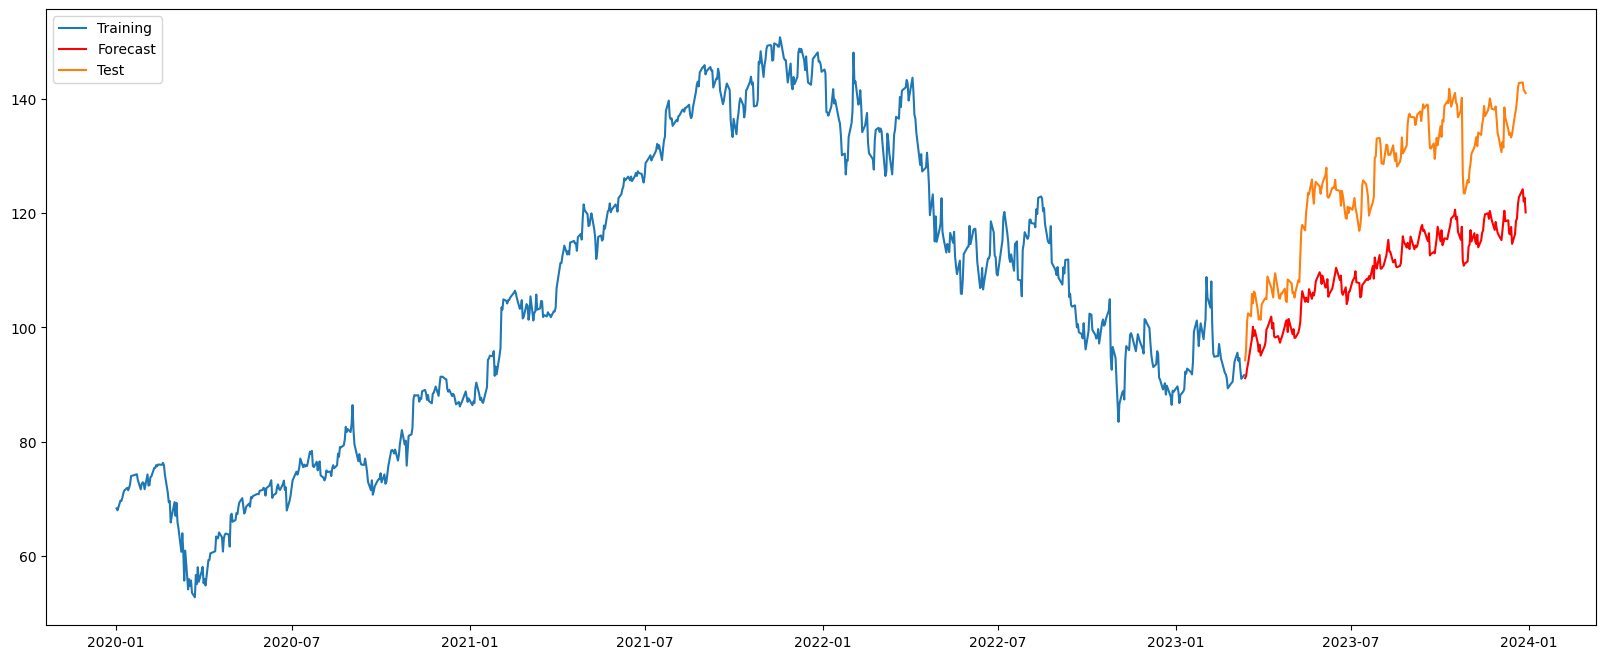

In [158]:
# Plot training, test and forecast data

plt.figure(figsize=(20,8))

plt.plot(training_data.index, training_data['Close'], label='Training')
plt.plot(testing_data.index, forecasted_values, label='Forecast', color='red')
plt.plot(testing_data.index, testing_data['Close'], label='Test')

plt.legend()
plt.show()

# Next Steps

* Improve the forecast by grid-search the optimal parameter
* Are there any extra exogenous variables that can be included?